In [39]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import top_k_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

In [40]:
# Read Data and convert to lowercase
df = pd.read_csv('data/data.csv', sep=',')
df = df.apply(lambda x: x.astype(str).str.lower())

In [41]:
# concat all languages into one Dataframe
dfs = list()
for lang in df.columns:
    df_lang = pd.DataFrame(df[lang])
    df_lang['lang'] = lang[:3]
    df_lang = df_lang.rename(columns={lang: 'word'})
    dfs.append(df_lang)
df2 = pd.concat(dfs, ignore_index=True)

In [42]:
df2.head()

,word,lang
0,as,ang
1,his,ang
2,that,ang
3,he,ang
4,was,ang


# Feature Engineering

In [43]:
def count_special_characters(word: str, string: str) -> int:
    num_special_characters=0
    for char in word:
        if char in string:
            num_special_characters+=1
    return num_special_characters

In [44]:
# Length
df2['len'] = df2['word'].str.len()

dict = {'vow':'aeiouAEIOU',
        'acc':'àèìòùÀÈÌÒÙáéíóúÁÉÍÓÚ',
        'accl':'àèìòùÀÈÌÒÙ',
        'accr':'áéíóúÁÉÍÓÚ',
        'die':'äëïöüÄËÏÖÜ',
        'cir':'âêîôûÂÊÎÔÛ', 
        'ñ':'ñÑ',
        'ç':'çÇ',
        'ale':'ß',
        'pol':'ąćęłńóśźżĄĆĘŁŃÓŚŹŻ', 
        'por':'ãõÃÕ',
        'rum':'ăâîșțĂÂÎȘȚ'}
for column in dict:
        df2[column] = df2['word'].apply(lambda row: count_special_characters(row, dict[column]))

In [45]:
df2.head()

,word,lang,len,vow,acc,accl,accr,die,cir,ñ,ç,ale,pol,por,rum
0,as,ang,2,1,0,0,0,0,0,0,0,0,0,0,0
1,his,ang,3,1,0,0,0,0,0,0,0,0,0,0,0
2,that,ang,4,1,0,0,0,0,0,0,0,0,0,0,0
3,he,ang,2,1,0,0,0,0,0,0,0,0,0,0,0
4,was,ang,3,1,0,0,0,0,0,0,0,0,0,0,0


In [46]:
df2['lang']=df2['lang'].astype('category').cat.codes

In [65]:
df2.corr().round(2)['lang']



C:\Users\jonny\AppData\Local\Temp\ipykernel_17456\3051748744.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2.corr().round(2)['lang']


lang    1.00
len     0.05
vow     0.15
acc    -0.04
accl   -0.05
accr   -0.02
die    -0.16
cir     0.08
ñ      -0.02
ç       0.03
ale    -0.06
pol     0.09
por     0.06
rum     0.19
Name: lang, dtype: float64

# Models

In [24]:
X = df2[['len', 'vow', 'acc', 'accl', 'accr', 'die', 'cir', 'ñ', 'ç', 'ale', 'pol', 'por', 'rum']]
y = df2['lang']

# Use PCA to reduce the dimensionality of the data
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)

# Split the data into training, testing and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2)

# Define the SVM model
model1 = svm.SVC(kernel='linear', probability=True)  # linear kernel
model2 = svm.SVC(kernel='poly', degree=3, probability=True)  # polynomial kernel with degree 3
model3 = svm.SVC(kernel='rbf', gamma=0.1, probability=True)  # RBF kernel with gamma = 0.1

model1_pca = svm.SVC(kernel='linear', probability=True)  # linear kernel
model2_pca = svm.SVC(kernel='poly', degree=3, probability=True)  # polynomial kernel with degree 3
model3_pca = svm.SVC(kernel='rbf', gamma=0.1, probability=True)  # RBF kernel with gamma = 0.1


In [29]:
X_train.head()

,len,vow,acc,accl,accr,die,cir,ñ,ç,ale,pol,por,rum
3796,6,2,0,0,0,0,0,0,0,0,0,0,0
5084,3,2,0,0,0,0,0,0,0,0,0,0,0
482,6,3,0,0,0,0,0,0,0,0,0,0,0
4666,7,3,0,0,0,0,0,0,0,0,0,0,0
206,5,1,0,0,0,0,0,0,0,0,0,0,0


In [47]:
# Train the models on the training data
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

model1_pca.fit(X_train_pca, y_train_pca)
model2_pca.fit(X_train_pca, y_train_pca)
model3_pca.fit(X_train_pca, y_train_pca)

SVC(gamma=0.1, probability=True)

In [48]:
# Evaluate the models on the test data
score1 = model1.score(X_test, y_test)
score2 = model2.score(X_test, y_test)
score3 = model3.score(X_test, y_test)
print(f'Model 1 accuracy: {score1 * 100}%')
print(f'Model 2 accuracy: {score2 * 100}%')
print(f'Model 3 accuracy: {score3 * 100}%\n')

# Evaluate the models on the test data
score1_pca = model1_pca.score(X_test_pca, y_test_pca)
score2_pca = model2_pca.score(X_test_pca, y_test_pca)
score3_pca = model3_pca.score(X_test_pca, y_test_pca)
print(f'Model 1 pca accuracy: {score1_pca * 100}%')
print(f'Model 2 pca accuracy: {score2_pca * 100}%')
print(f'Model 3 pca accuracy: {score3_pca * 100}%')

Model 1 accuracy: 30.111336032388664%
Model 2 accuracy: 26.214574898785425%
Model 3 accuracy: 29.706477732793523%

Model 1 pca accuracy: 29.453441295546558%
Model 2 pca accuracy: 24.544534412955464%
Model 3 pca accuracy: 28.289473684210524%


In [49]:
# Use the trained models to make predictions
predictions1 = model1.predict_proba(X_test)
predictions2 = model2.predict_proba(X_test)
predictions3 = model3.predict_proba(X_test)

predictions1_pca = model1_pca.predict_proba(X_test_pca)
predictions2_pca = model2_pca.predict_proba(X_test_pca)
predictions3_pca = model3_pca.predict_proba(X_test_pca)

In [50]:
print('Top 3 accuracy model 1 %f' % top_k_accuracy_score(y_test, predictions1, k=3))
print('Top 3 accuracy model 2 %f' % top_k_accuracy_score(y_test, predictions2, k=3))
print('Top 3 accuracy model 3 %f\n' % top_k_accuracy_score(y_test, predictions3, k=3))

print('accuracy model 1 pca %f' % top_k_accuracy_score(y_test_pca, predictions1_pca, k=3))
print('Top 3 accuracy model 2 pca %f' % top_k_accuracy_score(y_test_pca, predictions2_pca, k=3))
print('Top 3 accuracy model 3 pca %f' % top_k_accuracy_score(y_test_pca, predictions3_pca, k=3))



Top 3 accuracy model 1 0.547065
Top 3 accuracy model 2 0.536943
Top 3 accuracy model 3 0.556174

accuracy model 1 pca 0.540486
Top 3 accuracy model 2 pca 0.504049
Top 3 accuracy model 3 pca 0.554150


In [51]:
# Generate classification reports for the models
print(classification_report(y_test, model1.predict(X_test), zero_division=0))
print(classification_report(y_test, model2.predict(X_test), zero_division=0))
print(classification_report(y_test, model3.predict(X_test), zero_division=0))

print(classification_report(y_test_pca, model1_pca.predict(X_test_pca), zero_division=0))
print(classification_report(y_test_pca, model2_pca.predict(X_test_pca), zero_division=0))
print(classification_report(y_test_pca, model3_pca.predict(X_test_pca), zero_division=0))

              precision    recall  f1-score   support

         ale       0.27      0.31      0.29       184
         ang       0.18      0.65      0.29       185
         cat       0.62      0.04      0.08       198
         esp       0.59      0.10      0.17       203
         fra       0.54      0.14      0.22       199
         ita       0.24      0.35      0.28       200
         pol       0.96      0.48      0.64       189
         por       0.86      0.09      0.17       193
         rom       1.00      0.26      0.42       204
         sue       0.24      0.58      0.34       221

    accuracy                           0.30      1976
   macro avg       0.55      0.30      0.29      1976
weighted avg       0.55      0.30      0.29      1976

              precision    recall  f1-score   support

         ale       0.27      0.29      0.28       184
         ang       0.16      0.79      0.27       185
         cat       0.14      0.11      0.12       198
         esp       0.53 

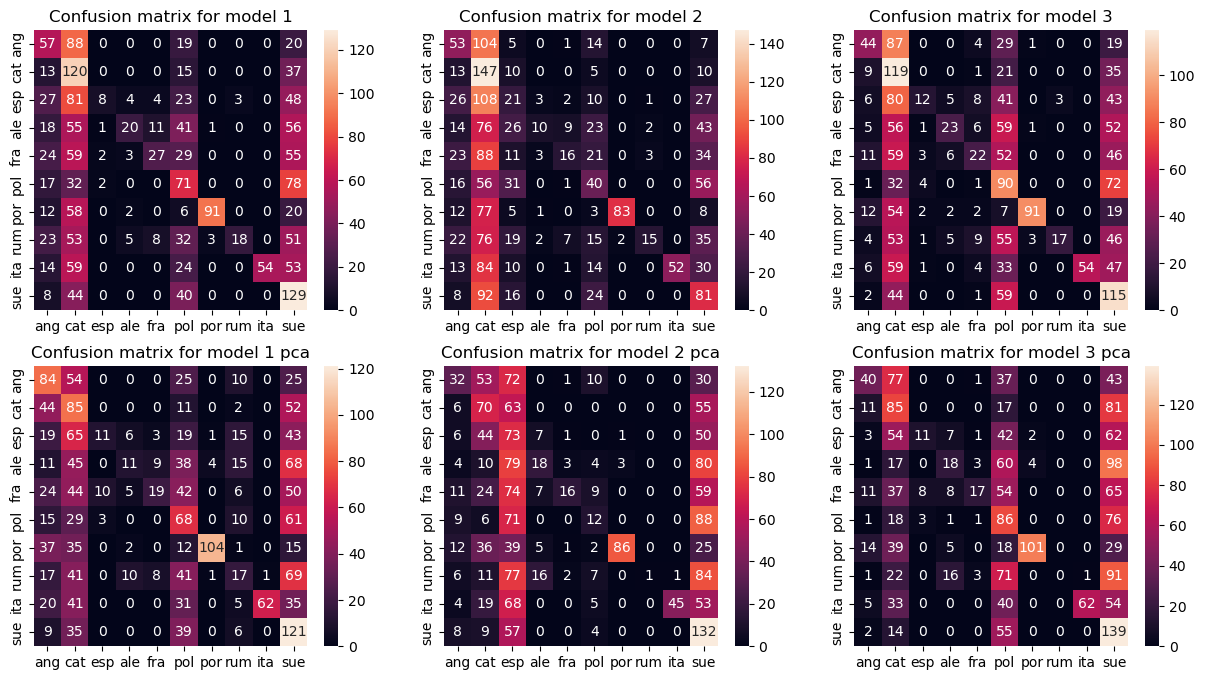

In [52]:
# Generate confusion matrices for the models and plot them as heatmaps try to make them look pretty,you can use seaborn for this
cm1 = confusion_matrix(y_test, model1.predict(X_test))
cm2 = confusion_matrix(y_test, model2.predict(X_test))
cm3 = confusion_matrix(y_test, model3.predict(X_test))

cm1_pca = confusion_matrix(y_test_pca, model1_pca.predict(X_test_pca))
cm2_pca = confusion_matrix(y_test_pca, model2_pca.predict(X_test_pca))
cm3_pca = confusion_matrix(y_test_pca, model3_pca.predict(X_test_pca))

# Plot the confusion matrices
langs =["ang", "cat", "esp", "ale", "fra", "pol", "por", "rum", "ita", "sue"]
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

sns.heatmap(cm1, annot=True, ax=ax[0][0], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm2, annot=True, ax=ax[0][1], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm3, annot=True, ax=ax[0][2], fmt='d', xticklabels=langs, yticklabels=langs)

sns.heatmap(cm1_pca, annot=True, ax=ax[1][0], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm2_pca, annot=True, ax=ax[1][1], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm3_pca, annot=True, ax=ax[1][2], fmt='d', xticklabels=langs, yticklabels=langs)

ax[0][0].set_title('Confusion matrix for model 1')
ax[0][1].set_title('Confusion matrix for model 2')
ax[0][2].set_title('Confusion matrix for model 3')

ax[1][0].set_title('Confusion matrix for model 1 pca')
ax[1][1].set_title('Confusion matrix for model 2 pca')
ax[1][2].set_title('Confusion matrix for model 3 pca')
plt.show()
